# Podcast RAG

## Overview

This sample demonstrates a Retrieval-Augmented Generation (RAG) system using a **Podcast episode** as the knowledge base, with text query capability.\
Initially an RSS feed link will be the input to allow the user to select and download a specific podcast episode. The selected audio undergoes preprocessing steps such as resampling and chunking to prepare it for transcription. 
Each chunk is transcribed to text using the [**Whisper base model**](https://huggingface.co/openai/whisper-base) via an Automatic Speech Recognition (ASR) pipeline optimized to run on **Intel® Core™ Ultra Processors** with [**PyTorch XPU backend**](https://pytorch.org/docs/stable/notes/get_start_xpu.html) for hardware acceleration. These transcriptions are then embedded using [**Teapot LLM**](https://huggingface.co/teapotai/teapotllm), creating a knowledge base.
User queries are handled by the Teapot RAG system so that it retrieves a relevant text response. 

## Workflow

- User provides an *RSS feed URL* to list available podcast episodes.
- The selected audio podcast episode is downloaded, resampled and then split into chunks.
- Each chunk is transcribed to text using the [*Whisper base model*](https://huggingface.co/openai/whisper-base) (ASR).
- Transcribed text chunks are embedded using the [*Teapot LLM*](https://huggingface.co/teapotai/teapotllm) to create a searchable knowledge base.
- A text query from the user is processed by the Teapot LLM RAG system, to get a relevant text response.

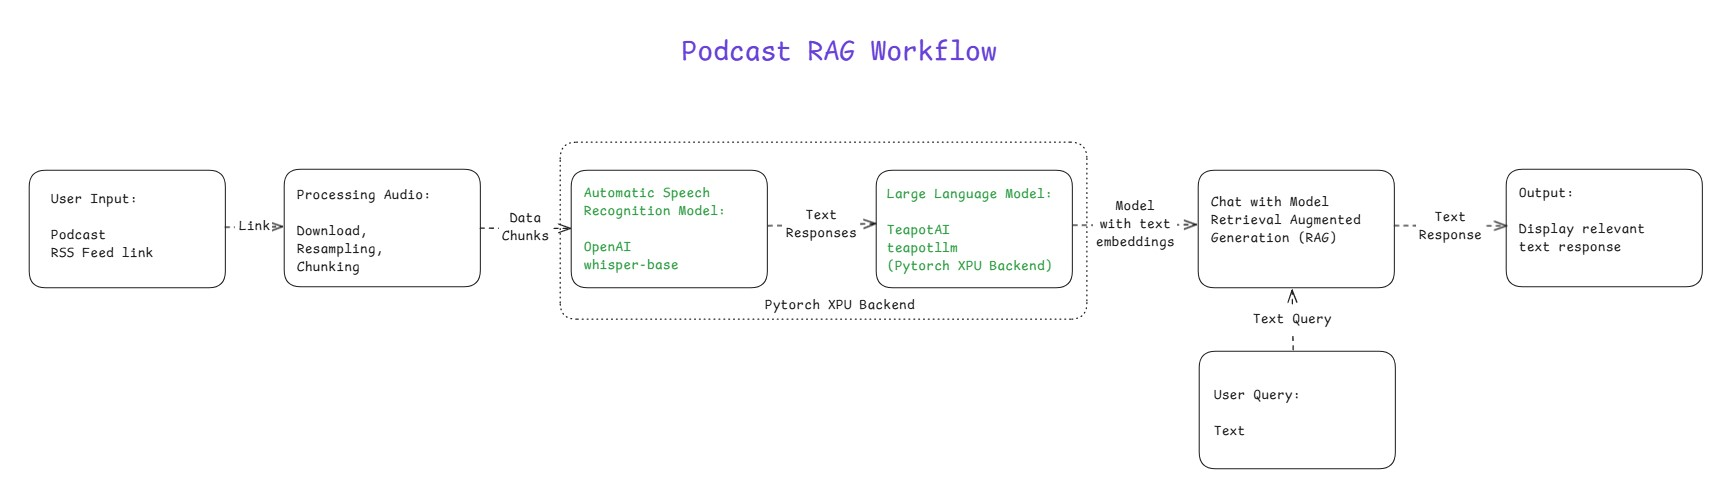

## Import necessary packages

Import all the necessary packages and libraries

In [1]:
import os
import torch
import logging
import requests
import feedparser
import torchaudio
import ipywidgets as widgets
from teapotai import TeapotAI
from urllib.parse import urlparse
from IPython.display import display
from huggingface_hub import notebook_login
from transformers import WhisperProcessor, WhisperForConditionalGeneration

logging.basicConfig(level=logging.INFO)

C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\teapotai\teapotai.py:87: SyntaxWarning: invalid escape sequence '\ '
  |_   _|__  __ _ _ __   ___ | |_      / \  |_ _|   __ /-___-\__/ /
C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\teapotai\teapotai.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "schema" in "TeapotTool" shadows an attribute in parent "BaseModel"
  warnings.warn(


## Login to Huggingface to download the models (Optional)
- Log in to [Huggingface](https://huggingface.co/) using your credentials.
- You’ll need a [User Access Token](https://huggingface.co/docs/hub/security-tokens), which you can generate from your [Settings](https://huggingface.co/settings/tokens) page. This token is used to authenticate your identity with the Hugging Face Hub.
- Once you've generated the token, copy it and keep it secure. Then, run the cell below and paste your access token when prompted.

In [2]:
notebook_login()

## Select podcast episode
Select the episode from the Podcast RSS Feed URL.

In [3]:
def select_podcast_episode(PODCAST_URL):
    """
    Fetches and displays a dropdown widget to select an episode.

    Args:
        PODCAST_URL: Podcast RSS feed URL

    Returns:
        dropdown: IPython widget for selecting podcast episode.
        episodes: List of episodes

    Raises:
        Exception : Raises an exception if there is any error while selecting the episode.
    """
    try:
        logging.info(f" Found podcast URL.")    	
        feed = feedparser.parse(PODCAST_URL)
        episodes = []
        for entry in feed.entries:
            audio_url = None
            if not audio_url and hasattr(entry, 'enclosures') and entry.enclosures:
                audio_url = entry.enclosures[0].href
            if audio_url:
                episodes.append({'title': entry.title, 'url': audio_url})
        logging.info(f" Found {len(episodes)} episodes")
        episode_titles = [ep['title'] for ep in episodes]
        dropdown = widgets.Dropdown(
            options=episode_titles,
            value=episode_titles[0],
            description='Episode:'
        )
        display(dropdown)
        return dropdown, episodes
    except Exception as e:
        logging.exception(f" Error while selecting the podcast: {str(e)}")

In [4]:
PODCAST_URL = "https://feed.podbean.com/openatintel/feed.xml"
dropdown, episodes = select_podcast_episode(PODCAST_URL)

INFO:root: Found podcast URL.
INFO:root: Found 100 episodes


Dropdown(description='Episode:', options=('Building Innovation with Open Source AI', 'Democratizing Kubernetes…

## Download Audio
Download the selected podcast episode

In [5]:
def download_selected_audio(dropdown, episodes):
    """
    Download the audio from the selected podcast episode.

    Args:
        dropdown: IPython widget for selecting podcast episode.
        episodes: List of episodes
        
    Returns:
        audio_path (str): The file path to the saved audio file.

    Raises:
        Exception: Raises an exception if there is any error during downloading the audio file.
    """
    try:
        OUTPUT_DIR = "downloads"
        selected_index = dropdown.index
        selected_url = episodes[selected_index]['url']
        logging.info(f" Selected episode: {episodes[selected_index]['title']}")
        logging.info(f" Audio URL: {selected_url}")
        logging.info(f" Downloading audio from: {selected_url}")
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        filename = os.path.basename(urlparse(selected_url).path)
        audio_path = os.path.join(OUTPUT_DIR, filename)
        response = requests.get(selected_url, timeout=10)
        with open(audio_path, 'wb') as f:
            f.write(response.content)
        logging.info(f" Audio saved to: {audio_path}")
        return audio_path
    except Exception as e:
        logging.exception(f" Error while downloading the podcast: {str(e)}")

In [6]:
audio_path = download_selected_audio(dropdown, episodes)

INFO:root: Selected episode: Building Innovation with Open Source AI
INFO:root: Audio URL: https://mcdn.podbean.com/mf/web/39af5nsnhjy8ckxr/OpenAtIntel_Ep111_MelissaMcKay-JFrog.mp3
INFO:root: Downloading audio from: https://mcdn.podbean.com/mf/web/39af5nsnhjy8ckxr/OpenAtIntel_Ep111_MelissaMcKay-JFrog.mp3
INFO:root: Audio saved to: downloads\OpenAtIntel_Ep111_MelissaMcKay-JFrog.mp3


## Initialize Audio Models
Initialize [*Whisper base model*](https://huggingface.co/openai/whisper-base) via Automatic Speech Recognition (ASR) pipeline.

In [7]:
def initialize_audio_models():
    """
    Initialize Automatic Speech Recognition (ASR) model.

    Returns:
        model : The loaded Whisper model
        processor: processor for pre-processing of audio input

    Raises:
        Exception: Raises an exception if there is any error during model or processor initialization.
    """
    try:
        model_id = "openai/whisper-base"
        device = "xpu" if torch.xpu.is_available() else "cpu"
        processor = WhisperProcessor.from_pretrained(pretrained_model_name_or_path=model_id)
        model = WhisperForConditionalGeneration.from_pretrained(pretrained_model_name_or_path=model_id)
        model = model.to(device)
        logging.info(" Model loaded!")
        return model, processor
    except Exception as e:
        logging.exception(f" Error while selecting the podcast: {str(e)}")

In [8]:
model, processor = initialize_audio_models()

INFO:root: Model loaded!


## Process podcast audio
The selected audio undergoes preprocessing steps such as resampling and chunking to prepare it for transcription.

In [9]:
def process_podcast_audio(audio_path, model, processor):
    """
    Process an audio file for transcription using a ASR model.

    Args:
        audio_path (str): The file path to the saved audio file.    
        model : The loaded Whisper model.
        processor: processor for pre-processing of audio input

    Returns:
        transcription_parts: List of transcribed text chunks from the audio file.

    Raises:
        Exception: Raises an exception if there is any error while processing the audio file.
    """
    try:
        waveform, sample_rate = torchaudio.load(audio_path)
        logging.info(f" Original sample rate: {sample_rate} Hz")
        logging.info(f" Audio shape: {waveform.shape}")
        
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            logging.info(" Converted stereo to mono")
        
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
            sample_rate = 16000
            logging.info(" Resampled to 16kHz")
            logging.info(f" Audio shape: {waveform.shape}")
        
        audio = waveform.squeeze().numpy()
        logging.info(f" Audio duration: {len(audio)/sample_rate:.1f} seconds")
        chunk_length = 22 * 16000   # 22 seconds
        overlap_length = 1 * 16000  # 1 second overlap
        transcription_parts = []
        total_chunks = len(audio) // chunk_length + (1 if len(audio) % chunk_length > 0 else 0)
        logging.info(f" Processing {total_chunks} chunks of audio..")
        for i in range(0, len(audio), chunk_length - overlap_length):
            chunk = audio[i:i + chunk_length]
            if len(chunk) < 1600:   # Less than 0.1 seconds, skip that chunk
                continue
            logging.info(f" Processing chunk {len(transcription_parts) + 1}/{total_chunks}...")
            input_features = processor(chunk, sampling_rate=16000, return_tensors="pt").input_features
            input_features = input_features.to('xpu')
            with torch.no_grad():
                predicted_ids = model.generate(input_features)
            chunk_transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]        
            transcription_parts.append(chunk_transcription)
            logging.info(f" Chunk {len(transcription_parts)}: {chunk_transcription}..")
        transcription = " ".join(transcription_parts)
        logging.info(f"\n\n Total length: {len(transcription)} characters")
        logging.info(f" Audio path: {audio_path}")
        logging.info(f" Word count: {len(transcription.split())}")
        logging.info(transcription)
        return transcription_parts
    except Exception as e:
        logging.exception(f" Error while processing the input audio query : {str(e)}")

In [10]:
transcription_parts = process_podcast_audio(audio_path, model, processor)

INFO:root: Original sample rate: 44100 Hz
INFO:root: Audio shape: torch.Size([2, 64359798])
INFO:root: Converted stereo to mono
INFO:root: Resampled to 16kHz
INFO:root: Audio shape: torch.Size([1, 23350494])
INFO:root: Audio duration: 1459.4 seconds
INFO:root: Processing 67 chunks of audio..
INFO:root: Processing chunk 1/67...
INFO:root: Chunk 1:  My company was really interested in getting involved in this product called a Kia. So it's, you know, an attempt to standardize this. To put things together in such a way that everyone can do it the same, we can all contribute, we can all pay attention to the details. Welcome to the OpenItIntel podcast, where we're all about open source from software..
INFO:root: Processing chunk 2/67...
INFO:root: Chunk 2:  source from software to security to innovation and beyond. I'm your host, Catherine Druckmann, an open source evangelist at Intel, bringing you leading edge, free-ranging conversations from some of the best minds in the open source commun

## Generate Embeddings
These audio data chunks are embedded using the Teapot LLM to form a searchable knowledge base.

In [11]:
def generate_embeddings(transcription_parts):
    """
    Generate embeddings for the list of transcribed text chunks.
    
    Args:
        transcription_parts (list): List of transcribed text chunks from the audio file.
    
    Returns:
        teapot_ai : Model with text embeddings.

    Raises:
        Exception: Raises an exception if there is any error while generating embeddings for the audio data chunks.
    """
    try:
        if transcription_parts:
            logging.info(" Found transcriptions.")
            teapot_ai = TeapotAI(documents=transcription_parts)
            logging.info(" Generated embeddings.")
            return teapot_ai
        else:
            logging.info(" Did not find any transcriptions.")
    except Exception as e:
        logging.exception(f" Error while generating embeddings using TeapotAI : {str(e)}")    

In [12]:
teapot_ai = generate_embeddings(transcription_parts)

INFO:root: Found transcriptions.


 _____                      _         _    ___        __o__    _;;
|_   _|__  __ _ _ __   ___ | |_      / \  |_ _|   __ /-___-\__/ /
  | |/ _ \/ _` | '_ \ / _ \| __|    / _ \  | |   (  |       |__/
  | |  __/ (_| | |_) | (_) | |_    / ___ \ | |    \_|~~~~~~~|
  |_|\___|\__,_| .__/ \___/ \__/  /_/   \_\___|      \_____/
               |_|   
Loading Model


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MTL2\.cache\huggingface\hub\models--teapotai--teapotllm. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\MTL2\seshu\AI-PC-Code-Samples\Audio-RAG\Podcast-RAG\.venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Generating embeddings for documents...


Document Embedding: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 36.93 doc/s]
INFO:root: Generated embeddings.


## Get response
Query is passed to the RAG system, which retrieves relevant information and generates a response.

In [13]:
def get_response(question, teapot_ai):
    """
    Get the response from the teapot RAG.

    Args:
        question (str): Input query
        teapot_ai : Model with text embeddings

    Returns:
        answer (str): Generated response from the RAG.

    Raises:
        Exception: Raises an exception if there is any error while getting the response.
    """
    try:
        if query:
            logging.info(f" Query: {query}\n")
            answer = teapot_ai.chat([
                {
                    "role":"system",
                    "content": "You are an agent designed to answer the questions."
                },
                {
                    "role":"user",
                    "content": question
                }
            ])
            logging.info(f" Response: {answer}")
            return answer
        else:
            logging.info(" Did not found the question.\n")
    except Exception as e:
        logging.exception(f" Error while generating response : {str(e)}")

In [14]:
query = "Whos is the host here?"
answer = get_response(query, teapot_ai)

INFO:root: Query: Whos is the host here?

INFO:root: Response: The host is Catherine Druckmann.


In [15]:
query = "what was the work of the host here"
answer = get_response(query, teapot_ai)

INFO:root: Query: what was the work of the host here

INFO:root: Response: The host was responsible for delivering the content on the website.


In [16]:
query = "What is OPEA?"
answer = get_response(query, teapot_ai)

INFO:root: Query: What is OPEA?

INFO:root: Response: OPEA is an acronym for Open Platform for Enterprise Applications.


In [17]:
query = "What is the podcast we are listening to?"
answer = get_response(query, teapot_ai)

INFO:root: Query: What is the podcast we are listening to?

INFO:root: Response: The podcast we are listening to is OpenItIntel.
